# Tuturial 1: Creating and Solving Factor Graphs
In this tutorial you will lear the basics of factor graphs and consepts such as variables, factors, priors and how create solve and explore them.

## What is a Factor Graph

Wikipedia tels us a factor graph is a bipartite graph representing the factorization of a function.
 
If you haven't taken some advanced statistics classes you are probably wondering, bipartite graph?, factorization?, I just want to navigate my robot.
For robotics, factor graphs are the common language used to describe your robot's estimation problem (the function) in a way both humans and computers can understand. 
The estimation problem can be anything from robot localization, structure from motion, calibration to full PoseSLAM with parametric or non-parametric measurements and beliefs.
A factor graph is a graphical model with two types of nodes, variables and factors, connected by edges between the variables and factors (bipartite graph). 
Variables represent the unknown random variables in the estimation problem, such as vehicle or landmark positions, sensor calibration parameters, and more.
Factors represent the algebraic interaction between particular variables, such as wheel odometry, which is captured through edges. 
Breaking down the complex system describing your robot to a graph of variables and factors is the factorization of the function decribing your system, such as the position and orientation (pose) of your robot at any given time. 
This factorisation allows us to solve the optimization problem for every variable given every measurement described by the factors.
See Caesar.jl docs [Graph Concepts](https://juliarobotics.org/Caesar.jl/latest/concepts/concepts/#Graph-Concepts) for more detail.

### Lets build a factor graph

First we will need some packages: 
- `GraphPlot` - for visualizing graphs.
- `DistributedFactorGraphs` - standardized API for interacting with factor graphs.
- `IncrementalInference` - Optimization routines for incremental non-parametric and parametric solutions based on factor graphs.
- `RoME` - Robot Motion Estimate: Tools, Variables, and Factors for SLAM in robotics.

In [18]:
using Pkg

Pkg.status()

      Status `~/Documents/persoonlik/NavAbility/ICRA/BinderNotebooks/Project.toml`
  [159f3aea] Cairo v1.0.5
  [b5cc3c7e] DistributedFactorGraphs v0.18.0
  [186bb1d3] Fontconfig v0.4.0
  [a2cc645c] GraphPlot v0.5.0
  [904591bb] IncrementalInference v0.27.0
  [91fb55c2] RoME v0.17.0 `https://github.com/JuliaRobotics/RoME.jl.git#master`
  [238d586b] RoMEPlotting v0.8.1 `~/.julia/dev/RoMEPlotting`


┌ Warning: `Scale.color_none` to be deprecated. Instead use e.g. `plot(..., Geom.contour, color=[colorant"black"])`
└ @ Gadfly.Scale /home/johan/.julia/packages/Gadfly/B5yQc/src/scale.jl:446
┌ Warning: `Scale.color_none` to be deprecated. Instead use e.g. `plot(..., Geom.contour, color=[colorant"black"])`
└ @ Gadfly.Scale /home/johan/.julia/packages/Gadfly/B5yQc/src/scale.jl:446
┌ Warning: `Scale.color_none` to be deprecated. Instead use e.g. `plot(..., Geom.contour, color=[colorant"black"])`
└ @ Gadfly.Scale /home/johan/.julia/packages/Gadfly/B5yQc/src/scale.jl:446
┌ Warning: `Scale.color_none` to be deprecated. Instead use e.g. `plot(..., Geom.contour, color=[colorant"black"])`
└ @ Gadfly.Scale /home/johan/.julia/packages/Gadfly/B5yQc/src/scale.jl:446
┌ Warning: `Scale.color_none` to be deprecated. Instead use e.g. `plot(..., Geom.contour, color=[colorant"black"])`
└ @ Gadfly.Scale /home/johan/.julia/packages/Gadfly/B5yQc/src/scale.jl:446


In [19]:
using GraphPlot
using DistributedFactorGraphs
using IncrementalInference
using RoME

To create a new factor graph with default settings use the `initfg()` function. 

In [20]:
fg = initfg();

## Variable and Factors 

Variables, denoted as the larger nodes in the figure below, represent state variables of interest such as vehicle or landmark positions, sensor calibration parameters, and more. Variables are likely hidden values which are not directly observed, but we want to estimate them them from observed data and at least some minimal algebra structure from probabilistic measurement models.

`RoME` provides variables and factors usefull to robotics.
We start with a `Pose2` variable, i.e. position and orientation in two dimensions.
To add variables to our factor graph `fg` we created above, call `addVariable` with the labels (`x0`,`x1`) and type `Pose2`

In [21]:
addVariable!(fg, :x0, Pose2);
addVariable!(fg, :x1, Pose2);

Lets have a look at the factor graph we have so far using `plotDFG`.

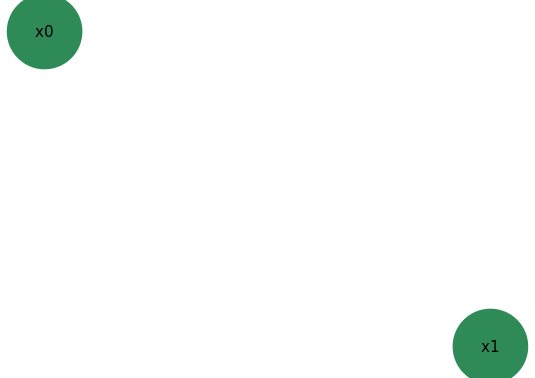

In [22]:
plotDFG(fg)

Factors, the smaller nodes in the figure, represent the algebraic interaction between particular variables, which is captured through edges. Factors must adhere to the limits of probabilistic models – for example conditional likelihoods capture the likelihood correlations between variables; while priors (unary to one variable) represent absolute information to be introduced. 

Since factors represents a probabilistic interaction between variables we need to specify the distribution our factor will represent. 
Lets look as a odometry factor that connects our two robot poses `x0` and `x1`.

[ Info: try doautoinit! of x0
[ Info: try doautoinit! of x1


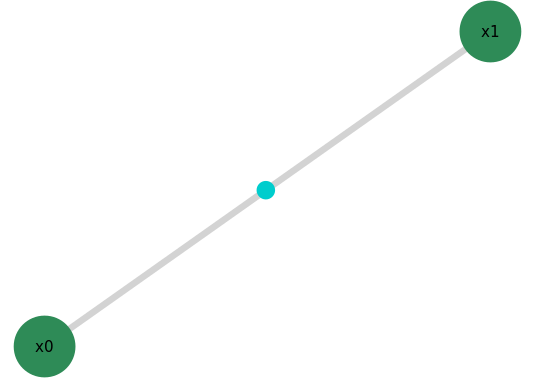

In [23]:
odo_distribution = MvNormal([1.0, 0.0, pi/2], diagm([0.1, 0.1, 0.01]))
fac_1 = addFactor!(fg, [:x0, :x1], Pose2Pose2(odo_distribution))

plotDFG(fg)

We now have a factor graph with 2 variable and one factor connecting them, but to solve it we need some additional information. 
In this example we need the estimated starting point of our robot.
We use unary factors called priors to represent absolute information to be introduced.


[ Info: try doautoinit! of x0
[ Info: init with useinitfct [:x0f1]
[ Info: do init of x0


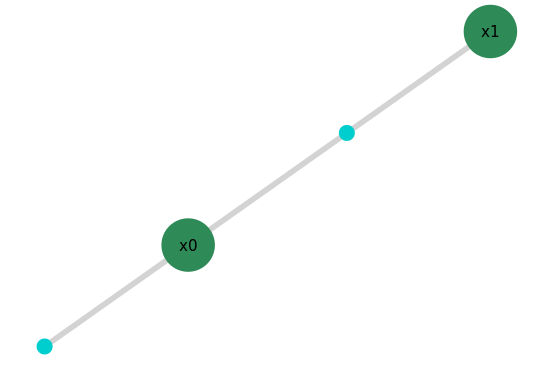

In [24]:
prior_distribution = MvNormal(zeros(3), diagm([0.5,0.5,0.1]))
addFactor!(fg, [:x0], PriorPose2(prior_distribution))

plotDFG(fg)

### Solving

We now have a graph we can solve.

In [34]:
solveGraph!(fg);

┌ Info: Ensure variables are all initialized (graphinit)
└ @ IncrementalInference /home/johan/.julia/packages/IncrementalInference/4aIs0/src/SolverAPI.jl:301
┌ Info: l1 is not initialized, and will do so now...
└ @ IncrementalInference /home/johan/.julia/packages/IncrementalInference/4aIs0/src/services/GraphInit.jl:379
[ Info: try doautoinit! of l1
[ Info: init with useinitfct [:x0l1f1]
[ Info: do init of l1
┌ Info: x3 is not initialized, and will do so now...
└ @ IncrementalInference /home/johan/.julia/packages/IncrementalInference/4aIs0/src/services/GraphInit.jl:379
[ Info: try doautoinit! of x3
[ Info: init with useinitfct [:x2x3f1]
[ Info: do init of x3
┌ Info: Solving over the Bayes (Junction) tree.
└ @ IncrementalInference /home/johan/.julia/packages/IncrementalInference/4aIs0/src/SolverAPI.jl:309
┌ Info: Bayes Tree Complete
└ @ IncrementalInference /home/johan/.julia/packages/IncrementalInference/4aIs0/src/JunctionTree.jl:797
┌ Info: Do tree based init-ference
└ @ IncrementalInf

Solve Progress: approx max 72, at iter 16 	 Time: 0:00:04

Solve Progress: approx max 72, at iter 27 	 Time: 0:00:17Solve Progress: approx max 72, at iter 28 	 Time: 0:00:17

┌ Info: CSM-5 Clique 2 finished, solveKey=default
└ @ IncrementalInference /home/johan/.julia/packages/IncrementalInference/4aIs0/src/CliqueStateMachine.jl:804


┌ Info: CSM-5 Clique 1 finished, solveKey=default
└ @ IncrementalInference /home/johan/.julia/packages/IncrementalInference/4aIs0/src/CliqueStateMachine.jl:804
Solve Progress: approx max 72, at iter 31 	 Time: 0:00:18Solve Progress: approx max 72, at iter 32 	 Time: 0:00:18

┌ Info: CSM-5 Clique 3 finished, solveKey=default
└ @ IncrementalInference /home/johan/.julia/packages/IncrementalInference/4aIs0/src/CliqueStateMachine.jl:804
Solve Progress: approx max 72, at iter 35 	 Time: 0:00:18


Building Bayes net...
Find potential functions for each clique


┌ Info: Finished tree based init-ference
└ @ IncrementalInference /home/johan/.julia/packages/IncrementalInference/4aIs0/src/SolverAPI.jl:363


### Results



In [26]:
using RoMEPlotting

In [27]:
#var1 = getVariable(fg, :x1)
pl = plotSLAM2D(fg, drawhist=true, drawPoints=false)

img = SVG("plot2d.svg", 6inch, 4inch)
draw(img, pl)

MethodError: MethodError: no method matching isfinite(::ProductRepr{Tuple{Vector{Float64}, Matrix{Float64}}})
Closest candidates are:
  isfinite(!Matched::Union{Type{T}, T}) where T<:Dates.TimeType at /opt/julia-1.7.1/share/julia/stdlib/v1.7/Dates/src/types.jl:415
  isfinite(!Matched::Union{Type{P}, P}) where P<:Dates.Period at /opt/julia-1.7.1/share/julia/stdlib/v1.7/Dates/src/periods.jl:57
  isfinite(!Matched::AbstractIrrational) at /opt/julia-1.7.1/share/julia/base/irrationals.jl:141
  ...

What is happening


In [36]:
var = getVariable(fg, :x1)

DFGVariable{Pose2...}
  manifold:   SpecialEuclidean(2)
  timestamp:  2022-02-13T17:31:10.347+02:00
   nstime:    0 nanoseconds
  label:      x1
  solvable:   1
  tags:       Set([:VARIABLE])
  # VND solveKeys=    (2)
  # initialized:      (true=2,false=0)
  # marginalized:     (true=0,false=2)
    :default <-- VariableNodeData
      initilized:        true
      marginalized:      false
      size bel. samples: (100,)
      kde bandwidths:    0.2033
     VNDs: [:default, :graphinit]
  # PPE solveKeys=    (1)
    :default <-- .suggested:    [1.012, -0.1144, 1.6582]
  VariableType: Pose2


In [31]:
getPPESuggested(fg, :x1)

3-element Vector{Float64}:
  1.148807552751389
 -0.015953491433986666
  1.5667824824964023

`getPPESuggested` returns a parametric point estimate for the current belief in variable `x1`.

Since the default solver is non-parametric a full belief function is available and can be visualized using `plotKDE`  `#FIXME explain KDE and the solver briefly`



Multiple planes stacked into Compose.Context, use Gadfly.draw(PNG(file.png,10cm,10cm),plothdl). Or PDF.
KDEPlotting01.jl/drawAllPairs -- supressing all exceptions for stacking empty contour plotsUndefRefError()


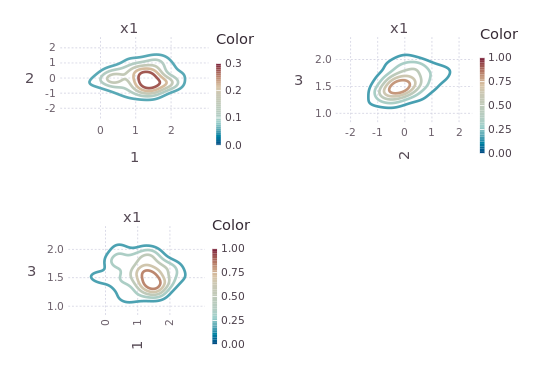

In [32]:
plotKDE(fg, :x1)

`#FIXME Explain what we see above`

### Adding more poses and a point landmark

`#TODO to close the loop`

In [33]:

addVariable!(fg, :l1, Point2)

p2br = Pose2Point2BearingRange(Normal(0.0,0.03),Normal(0.5,0.1))
addFactor!(fg, [:x0,:l1], p2br)

addVariable!(fg, :x2, Pose2)
addFactor!(fg, [:x1,:x2], Pose2Pose2(odo_distribution))

addVariable!(fg, :x3, Pose2)
addFactor!(fg, [:x2,:x3], Pose2Pose2(odo_distribution))



[ Info: try doautoinit! of l1
[ Info: try doautoinit! of x2
[ Info: try doautoinit! of x2
[ Info: init with useinitfct [:x1x2f1]
[ Info: do init of x2
[ Info: try doautoinit! of x3


DFGFactor{CommonConvWrapper{Pose2Pose2...}}
  timestamp:     2022-02-13T17:38:45.017+02:00
   nstime:       0 nanoseconds
  label:         x2x3f1
  solvable:      1
  VariableOrder: [:x2, :x3]
  multihypo:     Float64[]
  nullhypo:      0.0
  tags:          Set([:FACTOR])
  FactorType: Pose2Pose2{FullNormal}
Z:
FullNormal(
dim: 3
μ: [1.0, 0.0, 1.5708]
Σ: [0.1 0.0 0.0; 0.0 0.1 0.0; 0.0 0.0 0.01]
)



#TODO solve again with closed loop
#TODO solve on cloud
#TODO also do parametric
#TODO show the bayes tree and give a basic introduction on the solver